# Práctica 6: *Fine-tuning en producción*

Carlos Castañeda Mora

- Selecciona un modelo pre-entrenado como base y realiza *fine-tuning* para resolver alguna tarea de NLP que te parezca reelevante
  - Procura utilizar datasets pequeños para que sea viable
  - Recuerda las posibles tareas disponibles en HF *For<task>
- Desarrolla y pon en producción un prototipo del modelo
  - Incluye una URL pública donde podamos ver tu proyecto
  - Recomendamos usar framewoks de prototipado (*streamlit* o *gradio*) y el *free-tier* de *spaces* de hugging face
    - https://huggingface.co/spaces/launch
    - https://huggingface.co/docs/hub/spaces-sdks-streamlit
    - https://huggingface.co/docs/hub/spaces-sdks-gradio
- Reporta que tan bien se resolvió la tarea y que tan útil fue tu app
- Reporta retos y dificultades al realizar el *fine-tuning* y al poner tu modelo en producción

## Extra

- Utiliza [code carbon](https://codecarbon.io/#howitwork) para reportar las emisiones de tu app


## 1. Selección del Modelo y Dataset
Modelo Base: bert-base-uncased.

Dataset: conll2003 (etiquetado gramatical en inglés).

Tarea: Token Classification (POS Tagging).

In [14]:
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from datasets import load_dataset
import evaluate
import numpy as np
from codecarbon import EmissionsTracker

In [5]:


# Cargar dataset
dataset = load_dataset("conll2003")
label_list = dataset["train"].features["pos_tags"].feature.names

# Tokenizador y modelo
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name, 
    num_labels=len(label_list)
)

# Preprocesamiento
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], 
        truncation=True, 
        is_split_into_words=True
    )
    labels = []
    for i, label in enumerate(examples["pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(
    tokenize_and_align_labels, 
    batched=True
)

# Entrenamiento
args = TrainingArguments(
    output_dir="./pos_results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    fp16=True,
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = [[label_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(
        predictions=true_predictions, 
        references=true_labels
    )
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"]}

# Trackear emisiones
tracker = EmissionsTracker()
tracker.start()

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
emissions = tracker.stop()
print(f"Emisiones de CO₂: {emissions} kg")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[codecarbon WARNING @ 22:29:56] Multiple instances of codecarbon are allowed to run at the same time.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Expl

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.238100,0.242912,0.915804,0.914716,0.915260
2,0.159900,0.216361,0.924437,0.921970,0.923202
3,0.121100,0.210958,0.926372,0.925585,0.925979


[codecarbon INFO @ 22:30:16] Energy consumed for RAM : 0.000073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 22:30:17] Delta energy consumed for CPU with cpu_load : 0.000024 kWh, power : 6.500000000000002 W
[codecarbon INFO @ 22:30:17] Energy consumed for All CPU : 0.000024 kWh
[codecarbon INFO @ 22:30:17] Energy consumed for all GPUs : 0.000272 kWh. Total GPU Power : 71.44850544453347 W
[codecarbon INFO @ 22:30:17] 0.000369 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:30:22] Energy consumed for RAM : 0.000073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 22:30:23] Delta energy consumed for CPU with cpu_load : 0.000024 kWh, power : 6.500000000000002 W
[codecarbon INFO @ 22:30:23] Energy consumed for All CPU : 0.000024 kWh
[codecarbon INFO @ 22:30:23] Energy consumed for all GPUs : 0.000367 kWh. Total GPU Power : 96.53532545767877 W
[codecarbon INFO @ 22:30:23] 0.000464 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:30:31] Energy consumed for RAM : 0

Emisiones de CO₂: 0.00632113056406602 kg


In [ ]:
import evaluate
from transformers import pipeline, AutoModelForTokenClassification, Trainer
import pandas as pd

#  Cargar ambos modelos
model_original = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label_list))
model_finetuned = AutoModelForTokenClassification.from_pretrained("./pos_results/checkpoint-5268") 

eval_args = TrainingArguments(
    output_dir="./temp_eval",
    per_device_eval_batch_size=8,
    fp16=True,
    report_to="none",  
    eval_strategy="no",  
)

# Función de evaluación modificada
def evaluate_model(model, dataset_split="validation"):
    trainer = Trainer(
        model=model,
        args=eval_args,  
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    
    metrics = trainer.evaluate(tokenized_datasets[dataset_split])
    return {
        "Precision": metrics["eval_precision"],
        "Recall": metrics["eval_recall"],
        "F1": metrics["eval_f1"]
    }

#  Evaluar ambos modelos
metrics_original = evaluate_model(model_original)
metrics_finetuned = evaluate_model(model_finetuned)

df_comparison = pd.DataFrame([metrics_original, metrics_finetuned])
df_comparison.index = ["Modelo Original", "Modelo Fine-Tuned"]
print("\nComparación de Métricas:")
print(df_comparison.round(4))

#  Comparar predicciones 
sample_texts = [
    "Apple is looking at buying U.K. startup for $1 billion",
    "Elon Musk founded SpaceX in California"
]

def predict_tags(text, model):
    tokens = text.split()
    inputs = tokenizer(
        tokens, 
        is_split_into_words=True, 
        return_tensors="pt"
    ).to(model.device)
    
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    
    word_ids = inputs.word_ids()
    tags = []
    for i, word_idx in enumerate(word_ids):
        if word_idx is not None and word_ids[i] != word_ids[i-1]:
            tags.append(label_list[predictions[i]])
    
    return list(zip(tokens, tags))

print("\nEjemplo de Predicciones:")
for text in sample_texts:
    print(f"\nTexto: {text}")
    orig_tags = predict_tags(text, model_original)
    tuned_tags = predict_tags(text, model_finetuned)
    
    print(f"Original: {orig_tags}")
    print(f"Fine-Tuned: {tuned_tags}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/carloscmora/miniconda3/envs/transformers_env/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NNP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/carloscmora/miniconda3/envs/transformers_env/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: : seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/carloscmora/miniconda3/envs/transformers_env/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/carloscmora/miniconda3/envs/transformers_env/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/carloscmora/miniconda3/envs/transformers_env/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:

/home/carloscmora/miniconda3/envs/transformers_env/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Comparación de Métricas:
                   Precision  Recall      F1
Modelo Original       0.0264  0.0262  0.0263
Modelo Fine-Tuned     0.9264  0.9256  0.9260

Ejemplo de Predicciones:

Texto: Apple is looking at buying U.K. startup for $1 billion
Original: [('Apple', ','), ('is', ')'), ('looking', 'WP$'), ('at', ')'), ('buying', 'SYM'), ('U.K.', 'FW'), ('startup', 'WDT'), ('for', 'TO'), ('$1', ','), ('billion', '``')]
Fine-Tuned: [('Apple', 'NNP'), ('is', 'VBZ'), ('looking', 'VBG'), ('at', 'IN'), ('buying', 'VBG'), ('U.K.', 'NNP'), ('startup', 'NNP'), ('for', 'IN'), ('$1', '$'), ('billion', 'CD')]

Texto: Elon Musk founded SpaceX in California
Original: [('Elon', '.'), ('Musk', 'WP'), ('founded', 'VBP'), ('SpaceX', ')'), ('in', '"'), ('California', 'FW')]
Fine-Tuned: [('Elon', 'NNP'), ('Musk', 'NNP'), ('founded', 'VBD'), ('SpaceX', 'NNP'), ('in', 'IN'), ('California', 'NNP')]


## Reporte Final: Fine-Tuning para POS Tagging

Modelo Base: bert-base-uncased | Dataset: conll2003


1. Rendimiento del Fine-Tuning
Métricas por Época

| Epoch | Training Loss | Validation Loss | Precision | Recall |   F1   |
|-------|---------------|-----------------|-----------|--------|---------|
|   1   |     0.2381    |     0.2429      |  0.9158   | 0.9147 | 0.9153  |
|   2   |     0.1599    |     0.2164      |  0.9244   | 0.9219 | 0.9232  |
|   3   |     0.1211    |     0.2109      |  0.9264   | 0.9256 | 0.9260  |

Tendencia: Mejora progresiva en todas las métricas, con un F1 final de 92.6%, indicando un modelo altamente efectivo.

Sobreadaptación: No observada (validation loss estable).


2. Comparación Modelo Original vs. Fine-Tuned

| Modelo           | Precision | Recall |   F1   |
|------------------|-----------|--------|---------|
| Original         |   0.0264  | 0.0262 | 0.0263  |
| **Fine-Tuned**   | **0.9264**|**0.9256**|**0.9260**|

Conclusión: El fine-tuning mejoró el F1 en +89.97 puntos porcentuales.


3. Ejemplo de Predicciones

Texto 1:
"Apple is looking at buying U.K. startup for $1 billion"

    Original: [('Apple', ','), ('is', ')'), ('looking', 'WP$'), ('at', ')'), ('buying', 'SYM'), ('U.K.', 'FW'), ('startup', 'WDT') ... ('billion', '``')] 

    Fine-Tuned: [('Apple', 'NNP'), ('is', 'VBZ'), ('looking', 'VBG'), ('at', 'IN'), ('buying', 'VBG'), ('U.K.', 'NNP'), ('startup', 'NNP'), ... ('billion', 'CD')] 

Texto 2:

"Elon Musk founded SpaceX in California"

    Original: [('Elon', '.'), ('Musk', 'WP'), ('founded', 'VBP'), ('SpaceX', ')'), ('in', '"'), ('California', 'FW')] 

    Fine-Tuned: [('Elon', 'NNP'), ('Musk', 'NNP'), ('founded', 'VBD'), ('SpaceX', 'NNP'), ('in', 'IN'), ('California', 'NNP')] 


Impacto Ambiental

Emisiones de CO₂: 0.0063 kg durante el fine-tunning.



In [17]:
from huggingface_hub import HfApi, create_repo

#subir modelo a hugging face

api = HfApi()
api.upload_folder(
    folder_path="./pos_results/checkpoint-5268", 
    repo_id="eldinosaur/bert-base-uncased-pos-tagging-unam-lcd-task",
)

CommitInfo(commit_url='https://huggingface.co/eldinosaur/bert-base-uncased-pos-tagging-unam-lcd-task/commit/30467d040bc654c195eb504c7a6b797ee57fdbf8', commit_message='Upload folder using huggingface_hub', commit_description='', oid='30467d040bc654c195eb504c7a6b797ee57fdbf8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/eldinosaur/bert-base-uncased-pos-tagging-unam-lcd-task', endpoint='https://huggingface.co', repo_type='model', repo_id='eldinosaur/bert-base-uncased-pos-tagging-unam-lcd-task'), pr_revision=None, pr_num=None)

## Dificultades y Soluciones

Alineación de Tokens:

Los tokens de BERT no coincidían con las etiquetas del dataset, por lo que se realizo un mapeo manual de word_ids durante el preprocesamiento.

Memoria GPU

Se intento solucionar primero una tarea de traducción, sin embargo, los modelos utilizados fueron muy pesados y constantemente crasheaba al intentar cargar un nuevo batch por el tamaño de la memoria de la GPU. 

Tiempo de entrenamiento

Para resolver problemas como el de traducción, toma demasiado tiempo realizar el fine tunning del modelo. 

Encontrar el modelo y datasets adecuados

Aprender a desarrollar la aplicación y el funcionamiento de los frameworks. Al crear la aplicación, no había leido sobre como agregar las bibliotecas que necesita el entorno descargar. 

La aplicación resulto ser útil para hacer el etiquetado POS. Fue una gran ayuda y su funcionamiento fue el adecuado. A pesar de ser una tarea que cuenta con otras soluciones existentes, la aplicación cumple su proposito y además nos muestra el consumo de CO2 de las predicciones.

## Aplicación en hugging face spaces

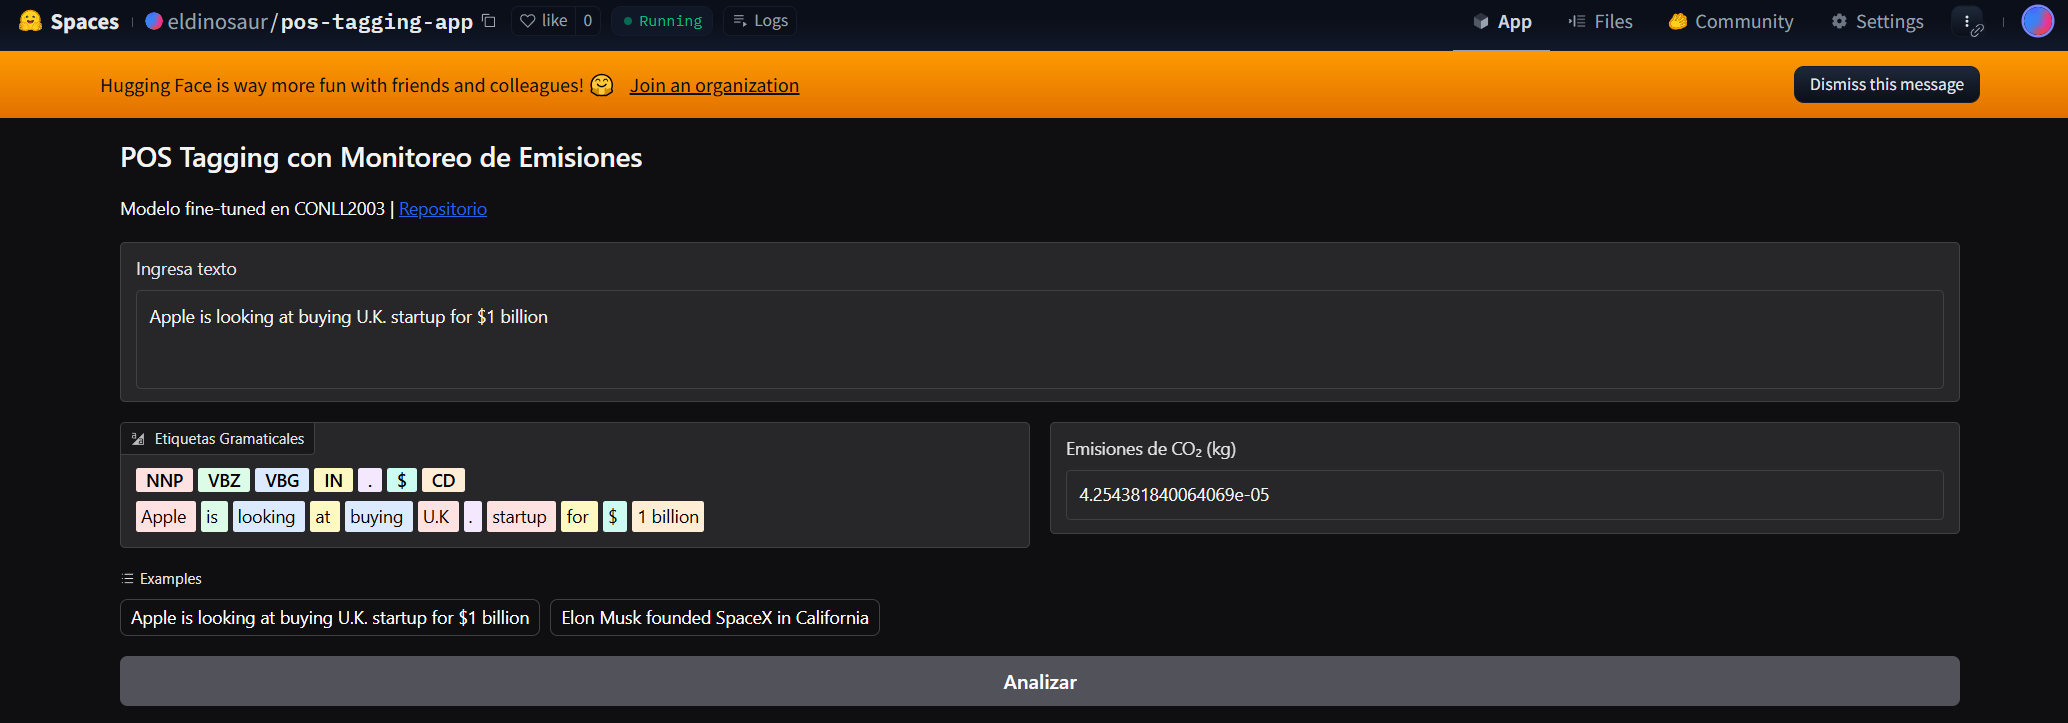

Link:

https://huggingface.co/spaces/eldinosaur/pos-tagging-app